In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.imputation.mice import MICE, MICEData
# import fancyimpute
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
import time
from collections import Counter

In [2]:
df = pd.read_csv("Clean Mapping.csv", sep=';',
                parse_dates=['adate', 'qdate', 'public_date', 'datadate'])

In [3]:
df.shape

(34727, 89)

In [4]:
df = df[df['splticrm'] != 'D']
df = df[df['splticrm'] != 'CCC']

In [5]:
#drop all rows where splticrm has NA values:
df = df[df['splticrm'].notna()]

In [6]:
Y = pd.factorize(df["splticrm"])[0]
print(np.bincount(Y))
print(pd.factorize(df["splticrm"])[1])

[3656 1943  990  296 5455 3209  489 3882 4682  199   50  143  382 1069
 1648 1096  220]
Index(['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+',
       'CCC+', 'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
      dtype='object')


In [7]:
X = df.loc[:, df.columns != "splticrm"]
X = X.drop(["permno", "CUSIP", "NCUSIP", "adate", "qdate", "public_date", "TICKER"], axis=1)
X = X.drop(["COMNAM", "PERMCO", "NWPERM", "gvkey", "datadate", "tic", "cusip", "conm", "PRC"], axis=1)
X.head()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward,Unnamed: 88
0,26.386,0.252,10.110,19.217,19.378,20.052,20.052,4.976,13.353,0.129,...,0.120,0.003,0.0,0.058,4.145,1.045,0.00867,2.221,1.554,NaN
1,28.226,0.252,10.110,20.542,20.714,21.435,21.435,5.323,14.285,0.129,...,0.120,0.003,0.0,0.058,4.434,1.117,0.00811,2.058,1.520,NaN
2,29.464,0.252,10.110,21.425,21.605,22.357,22.357,5.556,14.911,0.129,...,0.120,0.003,0.0,0.058,4.628,1.165,0.00778,2.146,1.586,NaN
3,28.783,0.233,10.983,21.378,21.556,23.096,23.096,5.381,15.909,0.177,...,0.121,0.003,0.0,0.049,4.515,1.545,0.00773,1.848,1.642,NaN
4,25.096,0.233,10.983,18.653,18.808,20.152,20.152,4.692,13.871,0.177,...,0.121,0.003,0.0,0.049,3.937,1.348,0.00886,1.612,1.432,NaN


In [8]:
bool = X.isnull().sum() > 10000
delCol = X.columns[bool]
X = X.drop(delCol, axis=1)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [10]:
#now do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=Y)

In [11]:
X_train.head(1)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward
14340,24.262,0.821,7.499,9.469,9.551,9.721,9.721,2.777,12.688,0.238,...,0.917,18.666,0.0,0.0,0.287,0.027,1.517,0.0151,0.208,0.669


In [12]:
X_train.isna().sum()

CAPEI               44
bm                 552
evm                 75
pe_op_basic        271
pe_op_dil          274
                  ... 
accrual             28
ptb                552
DIVYIELD          3999
PEG_1yrforward     818
PEG_ltgforward    1292
Length: 70, dtype: int64

In [13]:
## define function for IterativeImputer

from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#def iterative_imputer(df):
   # """ Impute the missing values (NaN) with the IterativeImputer
    
    #Args:
     #   df: feature matrix with NaN values to be imputed
    #"""
    #Define all column with numeric values (the features)
    #num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
     #       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
      #      'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       #     'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
        ##    'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
          #  'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
           ## 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            #'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            #'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

    # Copy df to df_imputed
    #df_imputed = df[num_cols].copy(deep=True)

    # Initialize IterativeImputer
    #mice_imputer = IterativeImputer()

    # Impute using fit_tranform on df
    #df_imputed.iloc[:, :] = mice_imputer.fit_transform(df[num_cols])
    

In [14]:
# apply IterativeImputer
### here I still have to implement the correct function

num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
            'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
            'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
            'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
            'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
            'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
            'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

# Copy df to df_mice_imputed
X_train_imputed = X_train[num_cols].copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer(random_state=0)

# Impute using fit_tranform on diabetes
X_train_imputed.iloc[:, :] = mice_imputer.fit_transform(X_train[num_cols])

# Copy df to df_mice_imputed
X_test_imputed = X_test[num_cols].copy(deep=True)

# Impute using fit_tranform on diabetes
X_test_imputed.iloc[:, :] = mice_imputer.transform(X_test[num_cols])


/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [15]:
# impute the missing values with IterativeImputer

#X_train_imputed = iterative_imputer(dataframe=X_train)
#X_test_imputed = iterative_imputer(dataframe=X_test)


In [16]:
from sklearn.ensemble import RandomForestClassifier

def feature_selection(x, y, thres):
    """ Find out, which the most important features are. Return a list of the most important features
        which wil be used for the algorithms.
    
    Args:
        x: feature input without NaN values
        y: classification input
        thres: input as percentage value, features with relative importance over this value will be in the output 
    """
    
    feat_labels = x.columns[:]
    
    # Create Random Forest object, fit data and
    # extract feature importance attributes
    forest = RandomForestClassifier(random_state=1, class_weight='balanced')
    forest.fit(x, y)
    importances = forest.feature_importances_
    
    #Define n as number of importances over the value thres
    n = sum(importances > thres)
    
    # Get cumsum of the n most important features
    feat_imp = np.sort(importances)[::-1]
    sum_feat_imp = np.cumsum(feat_imp)[:n]
    
    # Sort output (by relative importance) and 
    # print top n features
    indices = np.argsort(importances)[::-1]
    for i in range(n):
        print('{0:2d}) {1:7s} {2:6.4f}'.format(i + 1, 
                                           feat_labels[indices[i]],
                                           importances[indices[i]]))
        
    
    # Plot Feature Importance (both cumul., individual)
    plt.figure(figsize=(12, 8))
    plt.bar(range(n), importances[indices[:n]], align='center')
    plt.xticks(range(n), feat_labels[indices[:n]], rotation=90)
    plt.xlim([-1, n])
    plt.xlabel('Feature')
    plt.ylabel('Rel. Feature Importance')
    plt.step(range(n), sum_feat_imp, where='mid', 
         label='Cumulative importance')
    plt.tight_layout();
    
    
    # Create a list with the important features for ML algorhithms
    feature_list = [None] * n
    for i in range(n):
        feature_list[i] = feat_labels[indices[i]]
    
    # return the list of important features
    return feature_list
    

/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 1) intcov_ratio 0.0296
 2) int_totdebt 0.0294
 3) cfm     0.0291
 4) lt_debt 0.0232
 5) CAPEI   0.0225
 6) gpm     0.0224
 7) rect_turn 0.0219
 8) debt_ebitda 0.0213
 9) debt_assets 0.0209
10) at_turn 0.0195
11) inv_turn 0.0192
12) DIVYIELD 0.0186
13) lt_ppent 0.0184
14) invt_act 0.0182
15) profit_lct 0.0182
16) debt_at 0.0182
17) pretret_noa 0.0179
18) equity_invcap 0.0179
19) debt_capital 0.0178
20) intcov  0.0176
21) dltt_be 0.0173
22) dpr     0.0172
23) curr_ratio 0.0171
24) opmbd   0.0171
25) cash_ratio 0.0169
26) GProf   0.0165
27) rect_act 0.0165
28) debt_invcap 0.0160
29) cash_lt 0.0159
30) int_debt 0.0157


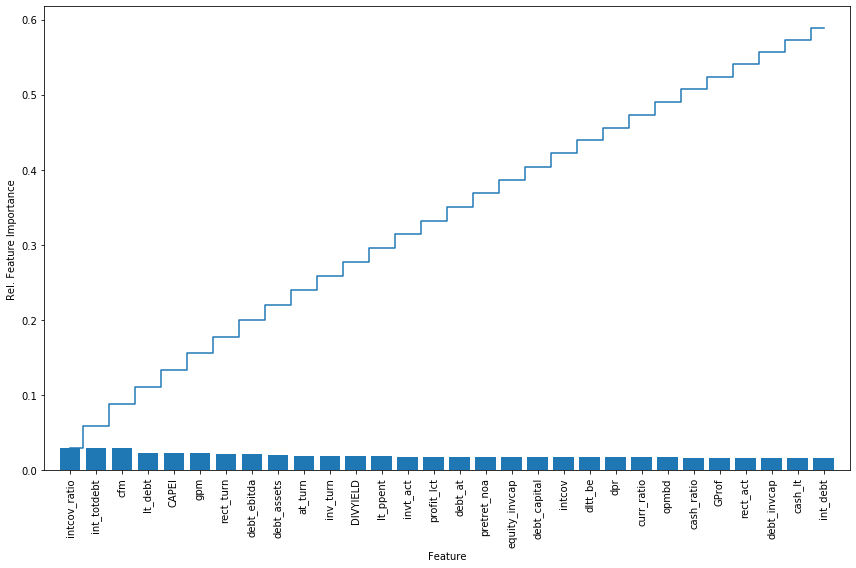

In [17]:
important_features = feature_selection(x = X_train_imputed, y = y_train, thres = 0.015)

In [18]:
#Subset important features matrix for ML algorithms
X_train_imputed = X_train_imputed.loc[:,important_features]
X_test_imputed = X_test_imputed.loc[:, important_features]

In [19]:
X_train_imputed.head(5)

,intcov_ratio,int_totdebt,cfm,lt_debt,CAPEI,gpm,rect_turn,debt_ebitda,debt_assets,at_turn,...,dltt_be,dpr,curr_ratio,opmbd,cash_ratio,GProf,rect_act,debt_invcap,cash_lt,int_debt
14340,6.935,0.064,0.242,0.373,24.262,0.369,16.133,1.686,0.599,0.368,...,0.338,0.238,1.293,0.369,0.559,0.136,0.262,0.358,0.063,0.065
19314,9.169,0.062,0.071,0.359,15.834,0.342,55.978,1.358,0.542,1.598,...,0.419,0.513,1.267,0.106,0.159,0.547,0.079,0.298,0.084,0.073
21873,2.071,0.070,0.117,0.567,53.426,0.285,6.467,4.869,0.808,0.392,...,3.303,0.760,1.000,0.272,0.383,0.112,0.311,0.705,0.092,0.079
11907,2.074,0.046,0.157,0.436,18.978,0.285,5.377,5.248,0.780,0.220,...,0.956,1.440,0.593,0.285,0.017,0.076,0.418,0.607,0.003,0.055
20313,5.653,0.036,0.112,0.484,45.632,0.524,5.068,3.294,0.659,0.625,...,0.778,0.394,1.340,0.187,0.218,0.328,0.486,0.484,0.063,0.044
